In [58]:
# Standard imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings
import plotly.express as px
from sklearn.cluster import KMeans
# Loading sklearn functionality from prior lessons
from sklearn.datasets import load_breast_cancer, load_wine
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from tempfile import mkdtemp
from itertools import product
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder

In [20]:
# Global plotting parameters
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams["axes.grid"] = True

# Brand colors dictionary
brand_colors = {
    "Denim": "#1358DB",
    "Supernova": "#FFCF00",
    # "Black": "#000000",
    # "Dark Blue": "#101D42",
    # "White": "#FFFFFF",
    "Dark Gray": "#6F6F6F",
    # "Light Gray 1": "#F6F6F4",
    "Light Gray 2": "#ADBDCC"
}

# Create a matplotlib colormap
brand_cmap = plt.cm.colors.ListedColormap(list(brand_colors.values()))
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=brand_colors.values())
filterwarnings(action='ignore')

In [21]:
df = pd.read_csv("C:/Users/klink/Downloads/new_york_listings.csv")

In [22]:
# EDA Analysis 

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22308 entries, 0 to 22307
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      22308 non-null  int64  
 1   name                            22308 non-null  object 
 2   neighbourhood_group             22308 non-null  object 
 3   neighbourhood                   22308 non-null  object 
 4   latitude                        22308 non-null  float64
 5   longitude                       22308 non-null  float64
 6   room_type                       22308 non-null  object 
 7   price                           22308 non-null  float64
 8   minimum_nights                  22308 non-null  int64  
 9   number_of_reviews               22308 non-null  int64  
 10  calculated_host_listings_count  22308 non-null  int64  
 11  availability_365                22308 non-null  int64  
 12  number_of_reviews_ltm           

In [24]:
price_index = df.columns.get_loc('price')
monthly_values = df['price'] * 30
df.insert(loc=price_index + 1, column='month_price', value=monthly_values)

In [25]:
df.head(5)

Unnamed: 0                                               name  \
0           1                   Only 2 stops to Manhattan studio   
1           2  Uptown Sanctuary w/ Private Bath (Month to Month)   
2           3                            UES Beautiful Blue Room   
3           5      Perfect for Your Parents, With Garden & Patio   
4           6                 Sunny Williamsburg Loft with Sauna   

  neighbourhood_group neighbourhood   latitude  longitude        room_type  \
0            Brooklyn  Williamsburg  40.709350 -73.953420  Entire home/apt   
1           Manhattan   East Harlem  40.801070 -73.942550     Private room   
2           Manhattan   East Harlem  40.787780 -73.947590     Private room   
3            Brooklyn   Fort Greene  40.691940 -73.973890     Private room   
4            Brooklyn  Williamsburg  40.718807 -73.956177  Entire home/apt   

   price  month_price  minimum_nights  number_of_reviews  \
0   96.0       2880.0              30                194   
1   59.0       1770.0              30                  1   
2   67.0       2010.0              30                251   
3  195.0       5850.0               2                398   
4  290.0       8700.0              30                 13   

   calculated_host_listings_count  availability_365  number_of_reviews_ltm  
0                               1               173                      3  
1                               2                83                      0  
2                               1               264                      5  
3                               2               190                     36  
4                               1                 0                      1

In [26]:
roomtype = df['room_type'].value_counts()
print(roomtype)
neighbourhood = df['neighbourhood'].value_counts()
print(neighbourhood)
neighbourhood_group = df['neighbourhood_group'].value_counts()
print(neighbourhood_group)
minstay = df['minimum_nights'].value_counts()
print(minstay)

room_type
Entire home/apt    12664
Private room        9186
Hotel room           372
Shared room           86
Name: count, dtype: int64
neighbourhood
Bedford-Stuyvesant        1545
Midtown                   1461
Upper East Side           1042
Hell's Kitchen            1036
Harlem                    1031
                          ... 
Eltingville                  2
Willowbrook                  1
Fort Wadsworth               1
Chelsea, Staten Island       1
Oakwood                      1
Name: count, Length: 221, dtype: int64
neighbourhood_group
Manhattan        10205
Brooklyn          7455
Queens            3420
Bronx              912
Staten Island      316
Name: count, dtype: int64
minimum_nights
30     16138
1       2259
31      1297
2        896
3        661
       ...  
20         1
182        1
81         1
41         1
330        1
Name: count, Length: 76, dtype: int64


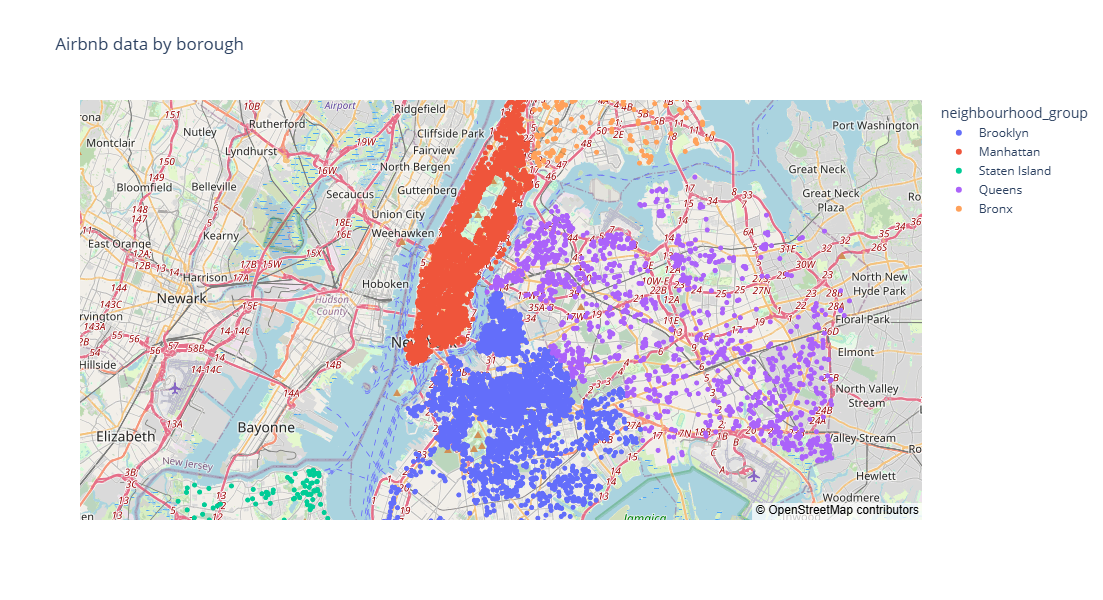

In [27]:
# results useing px scatter
filtered_df = df[df['room_type'] == 'Entire home/apt'].copy()
fig = px.scatter_map(filtered_df,lat="latitude",lon="longitude", hover_name="name", hover_data=["price", "neighbourhood"],color="neighbourhood_group",  # Changed from price to group name
    zoom=10, height=600, title="Airbnb data by borough")
fig.update_layout(map_style="open-street-map")
fig.show()

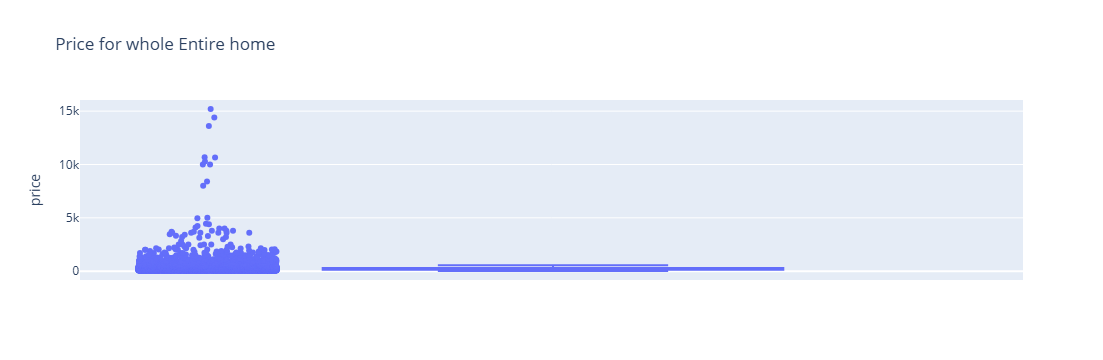

In [28]:
# not looking for data on room rentals - for investors need to target rental of whole home. 
fig = px.box(filtered_df, y="price",points="all", title="Price for whole Entire home",
    labels={'month_price': 'Price ($)'})
fig.show()

In [29]:
## Dealing with outliners -- Limiting to data where minimun stay is 30d + will take out "hotel" type daily/weekly pricing to identify monthly 
## pricing targets.

In [31]:
print(filtered_df
      .shape)

(12664, 14)


In [32]:
filtered_df3 = filtered_df[filtered_df['minimum_nights'] > 29]
print(filtered_df3.shape)

(11015, 14)


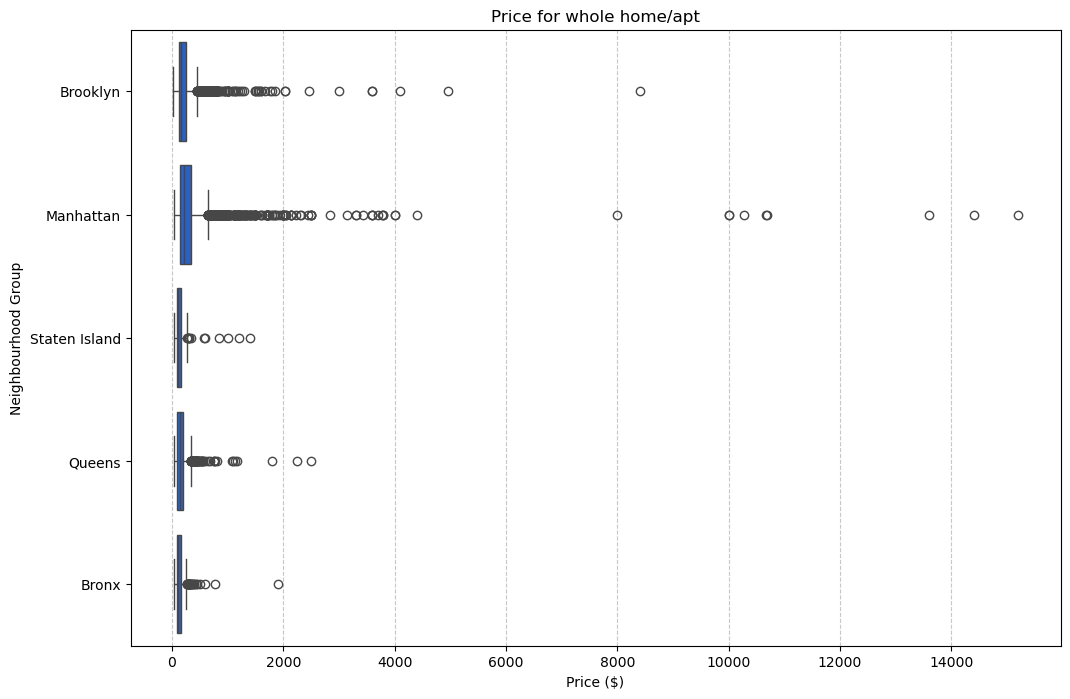

In [33]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=filtered_df3,x='price', y='neighbourhood_group')
plt.title('Price for whole home/apt')
plt.xlabel('Price ($)')
plt.ylabel('Neighbourhood Group')
plt.grid(axis='x', linestyle='--', alpha=0.7) # Optional: adds vertical gridlines
plt.show()

In [34]:
neighbourhood_group = filtered_df3['neighbourhood_group'].value_counts()
print(neighbourhood_group)

neighbourhood_group
Manhattan        6099
Brooklyn         3236
Queens           1216
Bronx             319
Staten Island     145
Name: count, dtype: int64


In [36]:
brooklyn_high_end = filtered_df3[
    (filtered_df3['neighbourhood_group'] == 'Brooklyn') & 
    (filtered_df3['price'] > 1000)]
brooklyn_high_end.head(20)

Unnamed: 0                                               name  \
786          1446                brooklyn 14 bedroom gated community   
2372         7179     Charming 2BR  Prime Carroll Gardens/ F,G Train   
2876         8733          Modern Luxury Living in Historic Brooklyn   
3392        10383                         Ditmas Park Victorian Home   
3907        11617      THE HIVE // Brand New 3-Story Luxury Townhome   
4713        13565             Magnificent Fort Greene Home- 3 Floors   
4806        13749                   Your Dream Event & Wedding Venue   
5265        14722                           Luxury Brownstone Duplex   
5556        15464             Bold and Beautiful Brooklyn Brownstone   
7283        18590                       Carlie’s Corner\nEvent space   
7496        18916        Spacious Light Cheerful Brooklyn Brownstone   
8086        19772                Historic Glamour in the Heart Of BK   
8380        20223                                                Jjj   
9727        22072  HISTORIC $10MLN MANSION IN THE HEART OF PARK S...   
10196       22754           Warm Contemporary Penthouse with Rooftop   
10713       23465  A Hidden speakeasy style event venue. (Full ve...   
11012       23862                  Elegant Triplex and Outdoor Oasis   
11106       23987  2000sqft Babyshowers,book signing Paint/sip Party   
11118       24001          Beautiful townhouse with a private garden   
11119       24003                  Open White Loft with Chef Kitchen   

      neighbourhood_group       neighbourhood   latitude  longitude  \
786              Brooklyn            Sea Gate  40.576010 -74.010720   
2372             Brooklyn     Carroll Gardens  40.679110 -73.995040   
2876             Brooklyn  Bedford-Stuyvesant  40.686377 -73.949349   
3392             Brooklyn            Flatbush  40.643940 -73.960570   
3907             Brooklyn          Greenpoint  40.726390 -73.946520   
4713             Brooklyn        Clinton Hill  40.684470 -73.968010   
4806             Brooklyn            Bushwick  40.698453 -73.921513   
5265             Brooklyn    Brooklyn Heights  40.699670 -73.994600   
5556             Brooklyn          Greenpoint  40.727490 -73.950690   
7283             Brooklyn           Flatlands  40.632780 -73.919640   
7496             Brooklyn  Bedford-Stuyvesant  40.682050 -73.953190   
8086             Brooklyn    Prospect Heights  40.680870 -73.974620   
8380             Brooklyn            Flatbush  40.645920 -73.956340   
9727             Brooklyn          Park Slope  40.669720 -73.974270   
10196            Brooklyn          Greenpoint  40.725660 -73.951380   
10713            Brooklyn  Bedford-Stuyvesant  40.696310 -73.946270   
11012            Brooklyn    Prospect Heights  40.676460 -73.969930   
11106            Brooklyn       Crown Heights  40.679870 -73.963890   
11118            Brooklyn         Cobble Hill  40.686930 -73.990850   
11119            Brooklyn          Greenpoint  40.723020 -73.952870   

             room_type   price  month_price  minimum_nights  \
786    Entire home/apt  2029.0      60870.0              30   
2372   Entire home/apt  1223.0      36690.0              30   
2876   Entire home/apt  1188.0      35640.0              30   
3392   Entire home/apt  1140.0      34200.0              30   
3907   Entire home/apt  1491.0      44730.0              30   
4713   Entire home/apt  1076.0      32280.0              30   
4806   Entire home/apt  1599.0      47970.0              30   
5265   Entire home/apt  1679.0      50370.0              31   
5556   Entire home/apt  1500.0      45000.0              30   
7283   Entire home/apt  1100.0      33000.0              30   
7496   Entire home/apt  1125.0      33750.0              30   
8086   Entire home/apt  3000.0      90000.0              30   
8380   Entire home/apt  1800.0      54000.0              30   
9727   Entire home/apt  2040.0      61200.0              30   
10196  Entire home/apt  3600.0     108000.0              

In [37]:
brooklyn_low_end = filtered_df3[
    (filtered_df3['neighbourhood_group'] == 'Brooklyn') & 
    (filtered_df3['price'] < 200)
]

# Display the first 20 examples
brooklyn_low_end.head(50)

Unnamed: 0                                               name  \
0             1                   Only 2 stops to Manhattan studio   
8            12                 Charming Brownstone 3 - Near PRATT   
9            13                     Greenpoint Place...Has It All!   
24           34                       Park Slope Green Guest House   
37           52                Wonderful Studio In Brooklyn, NY!!!   
39           56                                   Lovely Apartment   
53           80              Sunny, Modern 1 BR in E. Williamsburg   
66           96                 Creative South Williamsburg Studio   
97          141                      CHARMING CARROLL GARDENS APT.   
101         145             Cozy Garden Apartment  in Williamsburg   
112         164                      BEAUTIFUL 2 BEDROOM APARTMENT   
113         165     Brooklyn Cove 1 Br Apt w/ Garden In Bushwick!!   
134         194  Maison de sirenes 2, bohemian, ecclectic apart...   
139         199           Large Modern Park Slope 1BR with Balcony   
143         206                  Tree lined block modern apartment   
144         207                   Sweet Historic Greenpoint Duplex   
149         214                        Style in Stuyvesant Heights   
150         215                     Authentic New York City Living   
151         217                Garden apartment close to Manhattan   
162         234                   Large  Loft Style  Studio  Space   
165         241  Brooklyn- sunny, quiet, homelike-Park Slope South   
170         248                Cosy Sunny 1brm in Prospect Heights   
173         253   Cozy Williamsburg Apt,  1bd/1ba  (30day minimum)   
175         261                 Beautiful Grdn. Apt. in Park Slope   
180         267            Solo Travelers Private Garden XL Studio   
181         269                 Serene Park Slope Garden Apartment   
183         273                Ideal Brooklyn Brownstone Apartment   
185         277                      Welcome to Brooklyn! Bed-Stuy   
189         284  Sunny! 2br Steps to train/restaurants - 15 to NYC   
196         302  Modern  Condo w/Luxury Amenities by McCarren Park   
197         303        Chic Mini-Loft in the Heart of Williamsburg   
221         338                 Brooklyn Amazing 2bedrm Luxury Apt   
226         348                  Bright, Airy Loft Apt in Bushwick   
227         350                                    Red Hook Modern   
233         362                           Charming Brooklyn Studio   
282         442        Sunny top fl Private 1- BR with garden view   
296         468                  Apartment in Crown Heights, BKLYN   
298         471  DM reWeekly Rate: Lush Garden, Huge Kitchen, P...   
299         472                Bright and Quiet 2 BR in Park Slope   
304         483                 Spacious & Sunny in Prime Brooklyn   
305         484                1 Bedroom Apt - Close to JFK & City   
306         485              Lovely 2 BR in Brooklyn's Nicest Area   
321         513     Classic Williamsburg 2bdr with yard. Superhost   
336         544                 Cozy, Hella Sunny, and Convenient!   
338         546       BIG Light-Filled Loft Apartment & Art Studio   
342         550                 Elegant Stuyvesant Heights Retreat   
359         581                                    Brooklyn Livin'   
361         586  Vintage Vibes: Cozy Brooklyn Haven in Clinton ...   
362         587                   Brooklyn Apt: 1 Bedroom w/Garden   
364         595                XL 90m2 2BR Victorian area,sleeps 7   

    neighbourhood_group       neighbourhood   latitude  longitude  \
0              Brooklyn        Williamsburg  40.709350 -73.953420   
8              Brooklyn  Bedford-Stuyvesant  40.679460 -73.954170   
9              Brooklyn          Greenpoint  40.735350 -73.955840   
24             Brooklyn         South Slope  40.668600 -73.987230   
37             Brooklyn         Bensonhurst  40.619430 -73.992320   
39             Brook

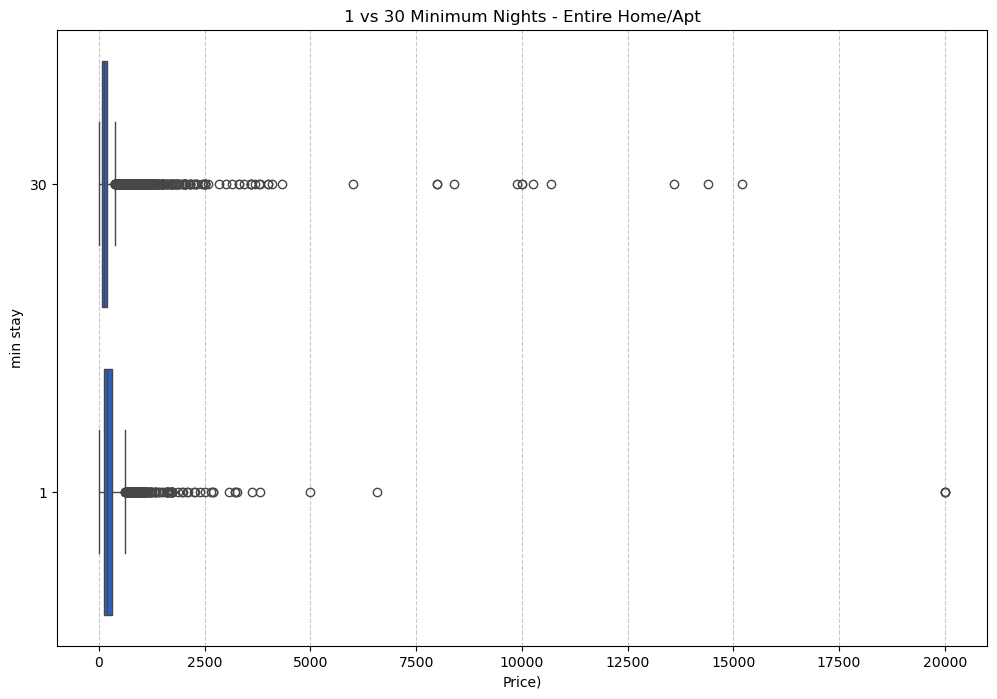

In [38]:
df_daily_sample = df[df['minimum_nights'].isin([1, 30])]
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_daily_sample,x='price',y=df_daily_sample['minimum_nights'].astype(str))
plt.title('1 vs 30 Minimum Nights - Entire Home/Apt')
plt.xlabel('Price)')
plt.ylabel('min stay')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


In [39]:
# How to deal with outliers - when looking at outliers unless someone is charganing 10K per night, these are actually monthly
# charges that were put in the system wrong. 
# So I need a model to split the 30d stays into ones that are likely monthly and those that are likely daily numbers
# So I will use k means to establish the breakpoint and then create a new column to house the daily rate (and calculate a daily 
# rate for those that look like they are monthly. 

In [40]:
# limit df to entire home and 30d stays
apt_data = df[(df['room_type'] == 'Entire home/apt') & (df['minimum_nights'] >= 30)]['price'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2, n_init=10, random_state=42).fit(apt_data)

#force a split one or the other. 
apt_breakpoint = min(apt_data[kmeans.labels_ == 0].max(), apt_data[kmeans.labels_ == 1].max())
print(f"Breakpoint of daily or monthly number: ${apt_breakpoint}")
df['adjusted_daily_price'] = np.nan # so all other room types and stays have nan

# had to have help with mask function
mask_30plus = df['minimum_nights'] >= 30
df.loc[mask_30plus & (df['price'] > apt_breakpoint), 'adjusted_daily_price'] = df['price'] / 30
df.loc[mask_30plus & (df['price'] <= apt_breakpoint), 'adjusted_daily_price'] = df['price']
print(df[['minimum_nights', 'price', 'adjusted_daily_price']].head(100))

Breakpoint of daily or monthly number: $4957.0
    minimum_nights  price  adjusted_daily_price
0               30   96.0                  96.0
1               30   59.0                  59.0
2               30   67.0                  67.0
3                2  195.0                   NaN
4               30  290.0                 290.0
..             ...    ...                   ...
95              30   71.0                  71.0
96              30   57.0                  57.0
97              30  171.0                 171.0
98              30  349.0                 349.0
99              30  199.0                 199.0

[100 rows x 3 columns]


  File "C:\Users\klink\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\klink\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\klink\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\klink\anaconda3\Lib\subprocess.

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22308 entries, 0 to 22307
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      22308 non-null  int64  
 1   name                            22308 non-null  object 
 2   neighbourhood_group             22308 non-null  object 
 3   neighbourhood                   22308 non-null  object 
 4   latitude                        22308 non-null  float64
 5   longitude                       22308 non-null  float64
 6   room_type                       22308 non-null  object 
 7   price                           22308 non-null  float64
 8   month_price                     22308 non-null  float64
 9   minimum_nights                  22308 non-null  int64  
 10  number_of_reviews               22308 non-null  int64  
 11  calculated_host_listings_count  22308 non-null  int64  
 12  availability_365                

In [43]:
Adj_daily_price_number = df['adjusted_daily_price'].value_counts()
print(Adj_daily_price_number)

adjusted_daily_price
150.0     328
100.0     312
120.0     267
200.0     255
90.0      242
         ... 
920.0       1
1622.0      1
494.0       1
526.0       1
1335.0      1
Name: count, Length: 874, dtype: int64


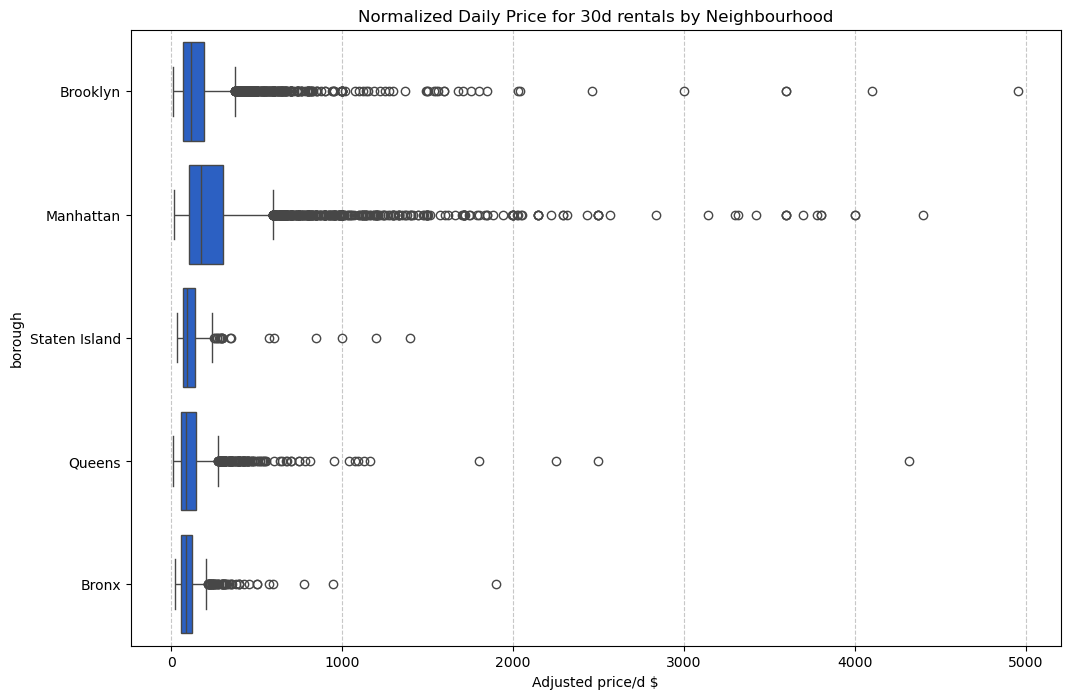

In [44]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[df['minimum_nights'] >= 30],x='adjusted_daily_price',y='neighbourhood_group')
plt.title('Normalized Daily Price for 30d rentals by Neighbourhood')
plt.xlabel('Adjusted price/d $')
plt.ylabel('borough')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [45]:
with pd.option_context('display.max_rows', 100): print(df[['minimum_nights', 'price', 'adjusted_daily_price']].head(100))

    minimum_nights  price  adjusted_daily_price
0               30   96.0                  96.0
1               30   59.0                  59.0
2               30   67.0                  67.0
3                2  195.0                   NaN
4               30  290.0                 290.0
5               30  216.0                 216.0
6               30  175.0                 175.0
7               30   90.0                  90.0
8               30  110.0                 110.0
9               30  115.0                 115.0
10              30  169.0                 169.0
11              30   97.0                  97.0
12               1  109.0                   NaN
13               1  136.0                   NaN
14              30  300.0                 300.0
15              30  230.0                 230.0
16              30   70.0                  70.0
17              30  150.0                 150.0
18              90  200.0                 200.0
19              30   94.0               

In [46]:
# MODELING PIPELINE 

In [47]:
## Preprocessing 

In [48]:
# Filter dataset for 'Entire home/apt' and 30+ day stays -- these is most relevant data for use with the project. the daily rates for people wanting 
# to rent out 1 -5 nights isn't going to compare as well to someone willing to do month to month. this is more like our target new 
# construction investments. Drop the colums not needed. 
df_ml = df[(df['room_type'] == 'Entire home/apt') & (df['minimum_nights'] >= 30)].dropna(subset=['adjusted_daily_price']).copy()
X = df_ml.drop(columns=['price', 'adjusted_daily_price', 'rate_type', 'name', 'Unnamed: 0'], errors='ignore')
y = df_ml['adjusted_daily_price']

In [51]:
# Preprocessing --- Scale numbers, tried One Hot Encoder for neighbourhood but too many, so looked up Target Encoder to use 
# for average of each neighourhood
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), ['latitude', 'longitude', 'number_of_reviews', 'availability_365']),
    ('cat_ohe', OneHotEncoder(handle_unknown='ignore'), ['neighbourhood_group', 'room_type']),
    ('cat_target', TargetEncoder(), ['neighbourhood'])])

In [52]:
# training split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.21, random_state=40)
# Models to test
models = {'Ridge': Ridge(alpha=1.0),'DecisionTree': DecisionTreeRegressor(max_depth=10, random_state=42),
          'RandomForest': RandomForestRegressor(n_estimators=100, random_state=43)}
# Do cross validataion w/kfold splits show each fold results
cv = KFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    pipe = Pipeline(steps=[('prepro', preprocessor), ('reg', model)])
    scores = -cross_val_score(pipe, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
    print(f" ")
    print(f"MODEL: {name}")
    for i, score in enumerate(scores, 1):
        print(f"Fold {i}: MAE = ${score:.2f}")
    print(f" ")
    print(f"AVG MAE: ${scores.mean():.2f}")
    print(f"DEV:+/- ${scores.std():.2f}")

 
MODEL: Ridge
Fold 1: MAE = $121.18
Fold 2: MAE = $123.81
Fold 3: MAE = $123.58
Fold 4: MAE = $126.05
Fold 5: MAE = $122.84
 
AVG MAE: $123.49
DEV:+/- $1.57
 
MODEL: DecisionTree
Fold 1: MAE = $123.34
Fold 2: MAE = $125.21
Fold 3: MAE = $125.16
Fold 4: MAE = $124.51
Fold 5: MAE = $119.10
 
AVG MAE: $123.46
DEV:+/- $2.28
 
MODEL: RandomForest
Fold 1: MAE = $110.42
Fold 2: MAE = $113.37
Fold 3: MAE = $115.16
Fold 4: MAE = $121.16
Fold 5: MAE = $112.48
 
AVG MAE: $114.52
DEV:+/- $3.66


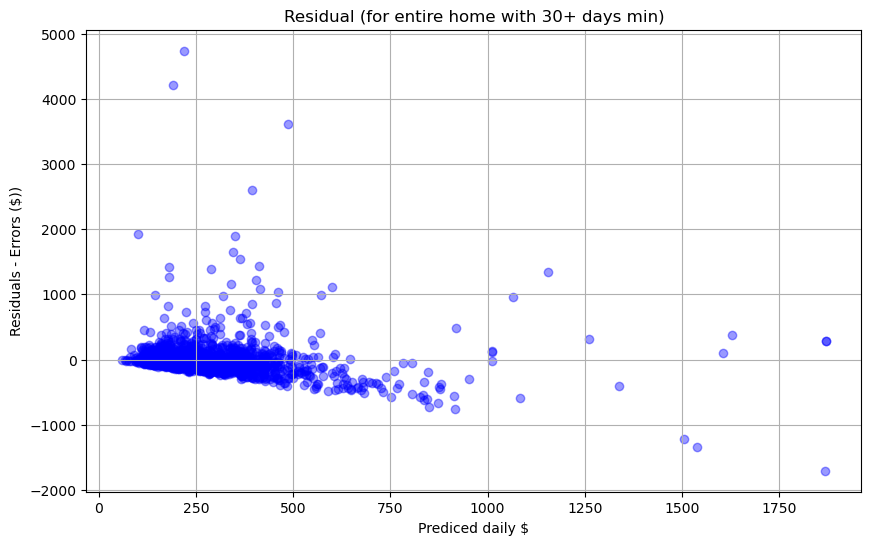

In [53]:
# Residual errors - few outliers 
rf_pipe = Pipeline(steps=[('prepro', preprocessor), ('reg', RandomForestRegressor(random_state=42))])
rf_pipe.fit(X_train, y_train)
y_pred = rf_pipe.predict(X_test)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.4, color='blue')
# plt.axhline(0, color='red', linestyle='--', lw=2)
plt.title('Residual (for entire home with 30+ days min)')
plt.xlabel('Prediced daily $')
plt.ylabel('Residuals - Errors ($))')
plt.show()

In [54]:
# Hyperparameter tuning 
param_grid = {'reg__n_estimators': [100, 300],'reg__max_depth': [None, 10, 20],'reg__min_samples_split': [2, 5, 10]}
grid_search = GridSearchCV(rf_pipe, param_grid,cv=5,scoring='neg_mean_absolute_error', n_jobs=-1,verbose=1)
grid_search.fit(X_train, y_train)
print(f"Optimal Parameters: {grid_search.best_params_}")
print(f"Improved MAE: ${-grid_search.best_score_:.2f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Optimal Parameters: {'reg__max_depth': 10, 'reg__min_samples_split': 2, 'reg__n_estimators': 300}
Improved MAE: $114.44


In [55]:
# Campare results from test data set. 

In [59]:
# Test performance of hyperparamiter  model with test data, show example of actual and new model 
final_model = grid_search.best_estimator_
final_preds = final_model.predict(X_test)
final_mae = mean_absolute_error(y_test, final_preds)
print(f"MAE Model Performance {final_mae:.2f}")
example_actual = y_test.iloc[0]
example_pred = final_preds[0]
print(f"Example Property - Actual {example_actual:.2f} | Predicted {example_pred:.2f}")

MAE Model Performance 115.96
Example Property - Actual 270.00 | Predicted 233.05


In [60]:
# Model performance would be a $3400 plus/minus per month (with the 113 daily plus/minus) which is big. Is the result better if we do it by NY city Borough?  
# not enough data in staten island
boroughs = df_ml['neighbourhood_group'].unique()
borough_results = {}
print("By Borough")
# had to get help on for loop 
for borough in boroughs:
    df_borough = df_ml[df_ml['neighbourhood_group'] == borough]
    X_b = df_borough.drop(columns=['price', 'adjusted_daily_price', 'rate_type', 'name', 'Unnamed: 0'], errors='ignore')
    y_b = df_borough['adjusted_daily_price']
    grid_b = GridSearchCV(rf_pipe, param_grid,cv=5, scoring='neg_mean_absolute_error',n_jobs=-1)
    grid_b.fit(X_b, y_b)
    best_mae = -grid_b.best_score_
    borough_results[borough] = {'MAE': best_mae,'Params': grid_b.best_params_}
    print(f"{borough:15} | Optimized MAE: ${best_mae:.2f}")
results_df = pd.DataFrame(borough_results).T
print("\nFinal Results Table:")
print(results_df[['MAE']])

By Borough
Brooklyn        | Optimized MAE: $113.50
Manhattan       | Optimized MAE: $144.17
Staten Island   | Optimized MAE: $nan
Queens          | Optimized MAE: $74.31
Bronx           | Optimized MAE: $66.78

Final Results Table:
                      MAE
Brooklyn       113.504881
Manhattan      144.170312
Staten Island         NaN
Queens           74.31474
Bronx           66.780721


In [61]:
# see what the numbers look like with an example for final results
final_model = grid_search.best_estimator_
results_df = pd.DataFrame({'neighbourhood_group': df_ml.loc[X_test.index, 'neighbourhood_group'],'actual': y_test,'predicted': final_model.predict(X_test)})
print(f"{'Borough':<10} | {'MAE':<10} | {'Example Actual':<2} | {'Example Predicted'}")
print("-" * 65)
# loop -- needed AI help to get loop to work 
for borough in results_df['neighbourhood_group'].unique():
    b_data = results_df[results_df['neighbourhood_group'] == borough]
    b_mae = mean_absolute_error(b_data['actual'], b_data['predicted'])
    ex_actual = b_data['actual'].iloc[0]
    ex_pred = b_data['predicted'].iloc[0] 
    print(f"{borough:<15} | ${b_mae:>8.2f} | ${ex_actual:>2.2f} | ${ex_pred:>2.2f}")
total_mae = mean_absolute_error(results_df['actual'], results_df['predicted'])
print("-" * 65)
print(f"{'AVG MAE:'} ${total_mae:.2f}")

Borough    | MAE        | Example Actual | Example Predicted
-----------------------------------------------------------------
Manhattan       | $  124.29 | $270.00 | $233.05
Brooklyn        | $  120.00 | $446.00 | $245.66
Queens          | $   74.35 | $151.00 | $241.94
Bronx           | $   87.47 | $214.00 | $127.44
Staten Island   | $   92.23 | $289.00 | $114.61
-----------------------------------------------------------------
AVG MAE: $115.96


In [62]:
# see what the numbers look like with an example for final results
final_model = grid_search.best_estimator_
results_df = pd.DataFrame({'neighbourhood_group': df_ml.loc[X_test.index, 'neighbourhood_group'],'actual': y_test, 
                           'predicted': final_model.predict(X_test)})
results_df['pct_err'] = (abs(results_df['actual'] - results_df['predicted']) / results_df['actual']) * 100
print(f"{'Borough':<10} | {'MAE':<10} | {'% Error':<10} | {'Ex. Actual':<12} | {'Ex. Pred'}")
print("-" * 75)
# loop -- needed AI help to get loop to work 
for borough in results_df['neighbourhood_group'].unique():
    b_data = results_df[results_df['neighbourhood_group'] == borough]
    b_mae = mean_absolute_error(b_data['actual'], b_data['predicted'])
    b_mape = b_data['pct_err'].mean() # Mean Absolute Percentage Error
    ex_actual = b_data['actual'].iloc[0]
    ex_pred = b_data['predicted'].iloc[0]
    print(f"{borough:<15} | ${b_mae:>8.2f} | {b_mape:>8.1f}% | ${ex_actual:>10.2f} | ${ex_pred:>10.2f}")
total_mae = mean_absolute_error(results_df['actual'], results_df['predicted'])
total_mape = results_df['pct_err'].mean()
print("-" * 75)
print(f" MAE ${total_mae:<8.2f} Avg % Error: {total_mape:.1f}%")

Borough    | MAE        | % Error    | Ex. Actual   | Ex. Pred
---------------------------------------------------------------------------
Manhattan       | $  124.29 |     57.7% | $    270.00 | $    233.05
Brooklyn        | $  120.00 |     51.9% | $    446.00 | $    245.66
Queens          | $   74.35 |     50.0% | $    151.00 | $    241.94
Bronx           | $   87.47 |     50.2% | $    214.00 | $    127.44
Staten Island   | $   92.23 |     55.7% | $    289.00 | $    114.61
---------------------------------------------------------------------------
 MAE $115.96   Avg % Error: 54.8%


In [63]:
# results - this error rate is likely not good enough for investment desisions. I would suggest a better analysis to determine what markets should
# be invested in would be utilizing a price to rent ratio calculation (Median Home Price / Median Annual Rent = Price-to-Rent Ratio) to determine
# markets that favors renters because the median house price is high and rents are low. I would utilize the HUD rent public data 
# (https://www.huduser.gov/portal/datasets/fmr/smallarea/index.html#query_2026) and zillow housing price info (https://www.zillow.com/research/data/) 
# to do this analysis. I had hoped to get to it but wasn't able to. This would be a much more accurate way to build a model for our clients.